# Working with EEG 2 dataset
EEG2 dataset from THINGS initiative: https://osf.io/anp5v/ (this pipeline is for subject 1)


In [1]:
import numpy as np
import mne, os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import nimfa

In [2]:
file_path = 'sub-01/preprocessed_eeg_training.npy'
data = np.load(file_path, allow_pickle=True).item()

In [3]:
data.keys(), data['preprocessed_eeg_data'].shape, data['ch_names'], data['times']

(dict_keys(['preprocessed_eeg_data', 'ch_names', 'times']),
 (16540, 4, 17, 100),
 ['Pz',
  'P3',
  'P7',
  'O1',
  'Oz',
  'O2',
  'P4',
  'P8',
  'P1',
  'P5',
  'PO7',
  'PO3',
  'POz',
  'PO4',
  'PO8',
  'P6',
  'P2'],
 array([-0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12,
        -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03,
        -0.02, -0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,
         0.07,  0.08,  0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,
         0.16,  0.17,  0.18,  0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,
         0.25,  0.26,  0.27,  0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,
         0.34,  0.35,  0.36,  0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,
         0.43,  0.44,  0.45,  0.46,  0.47,  0.48,  0.49,  0.5 ,  0.51,
         0.52,  0.53,  0.54,  0.55,  0.56,  0.57,  0.58,  0.59,  0.6 ,
         0.61,  0.62,  0.63,  0.64,  0.65,  0.66,  0.67,  0.68,  0.69,
         0.7 ,  0.71,  0.72,  0.73,  0.74,  0.75,  0.76,  0.77,  0

27084 events, 271 channels and 281 time points 

In [4]:
NOS_IMAGES = data['preprocessed_eeg_data'].shape[0]
NOS_REPS = data['preprocessed_eeg_data'].shape[1]
NOS_CHANNELS = data['preprocessed_eeg_data'].shape[2]
NOS_TIME_POINTS = data['preprocessed_eeg_data'].shape[3]
print(f"NOS_IMAGES: {NOS_IMAGES}, NOS_REPS: {NOS_REPS}, NOS_CHANNELS: {NOS_CHANNELS}, NOS_TIME_POINTS: {NOS_TIME_POINTS}")

NOS_IMAGES: 16540, NOS_REPS: 4, NOS_CHANNELS: 17, NOS_TIME_POINTS: 100


1. Apply baseline correction from before to after. data[time>0] - average(data[time<0]).
2. Remove and keep outliers
3. Zscore within channel for all channel.
4. matrix=matrix+abs(min(matrix))

Shape of averages data: (16540, 17, 100)
Min: -82.0258468137984, Max: 21.77091241347751
Mean: -0.03503607400085786, Stdev 0.47742839559771977
Shape of averages data: (16540, 17, 80)
Shape of averages data: (16540, 17, 80)


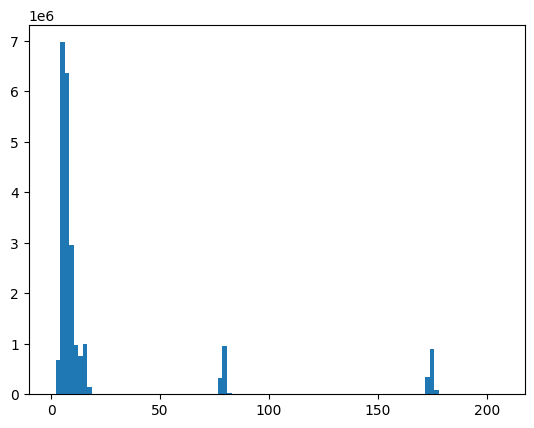

In [5]:
# processing the data
# mean over 4 reps
data_averaged = np.mean(data['preprocessed_eeg_data'], axis=1)
print(f"Shape of averages data: {data_averaged.shape}")
print(f"Min: {data_averaged.min()}, Max: {data_averaged.max()}")
print(f"Mean: {data_averaged.mean()}, Stdev {data_averaged.std()}") 

# applying baseline correction on data after t>0
# what are the indices of the time points less than zero
time_points = data['times']
nos_time_points_before_zero = len(time_points[time_points < 0])
baseilne = np.mean(data_averaged[:, :, :nos_time_points_before_zero], axis=2)
data_averaged = data_averaged[:,:,:-nos_time_points_before_zero] - baseilne[:, :, np.newaxis]
print(f"Shape of averages data: {data_averaged.shape}") 
# removing the outliers
# make all data more than 3 std to zero
# data_averaged[np.abs(data_averaged) > 3*data_averaged.std()] = 0
# # Applying z correction for data in each channel in vectorized manner
# Calculate mean and standard deviation along the (0, 2) axes for each slice in the second dimension
mean_vals = data_averaged.mean(axis=(0, 2)).reshape(1, 17, 1)
std_vals = data_averaged.std(axis=(0, 2)).reshape(1, 17, 1)
data_averaged = (data_averaged - mean_vals) / std_vals
min_vals = data_averaged.min(axis=(0, 2)).reshape(1, 17, 1)
data_averaged += np.abs(min_vals)
# for i in range(17):
#     data_averaged[:,i,:] = (data_averaged[:,i,:] - data_averaged[:,i,:].mean())/data_averaged[:,i,:].std()
#     data_averaged[:,i,:] = data_averaged[:,i,:] + np.abs(data_averaged[:,i,:].min())
print(f"Shape of averages data: {data_averaged.shape}")
# data_averaged = (data_averaged - data_averaged.mean())/data_averaged.std()
# data_averaged = data_averaged + np.abs(data_averaged.min())
hist = plt.hist(data_averaged[:,:,:].flatten(), bins=100)
# print("After removing outliers")
# print(f"Min: {data_averaged.min()}, Max: {data_averaged.max()}")
# print(f"Mean: {data_averaged.mean()}, Stdev {data_averaged.std()}")

In [6]:
def compute_evar_all(V: np.ndarray, W: np.ndarray, H: np.ndarray):
    V_hat = np.dot(W, H)
    rss = np.sum(np.asarray(V_hat - V)**2)
    evar_all = 1. - rss / (V*V).sum()
    return evar_all

def compute_evar_indiv(V: np.ndarray, W: np.ndarray, H: np.ndarray, d: int):
    V_hat_d = np.outer(W[:, d], H[d, :])
    rss = np.sum(np.asarray(V_hat_d - V)**2)
    evar_indiv = 1. - rss / (V*V).sum()
    return evar_indiv

def compute_evar_unique(V: np.ndarray, W: np.ndarray, H: np.ndarray, d: int, evar_all: float):
    V_hat_wo_d = np.dot(W[:, np.arange(W.shape[1]) != d], H[np.arange(H.shape[0]) != d, :])
    rss = np.sum(np.asarray(V_hat_wo_d - V)**2)
    evar_rest = 1. - rss / (V*V).sum()
    evar_unique = evar_all - evar_rest
    return evar_unique

In [7]:
def fit_bnmf(V: np.ndarray, k: int):
    bnmf = nimfa.Bd(V, seed='random_c', rank=k, max_iter=500, min_residuals=1e-4, alpha=np.zeros((V.shape[0], k)),
                        beta=np.zeros((k, V.shape[1])), theta=.0, k=.0, sigma=1., skip=100, stride=1,
                        n_w=np.zeros((k, 1)), n_h=np.zeros((k, 1)), n_run=1, n_sigma=False)
    bnmf_fit = bnmf()
    W = bnmf_fit.basis()
    H = bnmf_fit.coef()
    return np.array(W), np.array(H)

In [17]:
main_directory = 'training_images/'
image_array_path = 'things_image_array_eeg2.npy'
# if image_array_path exists 
# if image_array exists
try: 
    if image_array is not None:
        print("Image array loaded successfully")
except NameError:
    print("Image array not loaded")
    if os.path.exists(image_array_path):
        print(f"Loading image array from {image_array_path} ~ 4.5 mins")
        image_array = np.load(image_array_path)
    else:
        print(f"Creating image array from {main_directory} ~ 10 mins")
        # Dictionary to store images from each subfolder
        images_dict = {}

        # Iterate over all subfolders in the main directory
        for subfolder in os.listdir(main_directory):
            subfolder_path = os.path.join(main_directory, subfolder)
            if os.path.isdir(subfolder_path):
                # List to store images from the current subfolder
                images = []
                # Get all filenames in the subfolder and sort them
                filenames = sorted([f for f in os.listdir(subfolder_path) if f.endswith('.jpg')])
                # Iterate over sorted filenames
                for filename in filenames:
                    # Read the image
                    img = mpimg.imread(os.path.join(subfolder_path, filename))
                    # Append the image to the list
                    images.append(img)
                # Store the list of images in the dictionary
                images_dict[subfolder] = images
        sorted_keys = sorted(images_dict.keys(), key=lambda x: int(x.split('_')[0]))

        # maximum number of images in any subfolder
        max_images = 10 
        # Initialize an array to store the images
        # Assuming all images have the same shape, use the shape of the first image
        first_image_shape = images_dict['00001_aardvark'][0].shape  
        image_array = np.zeros((len(sorted_keys), max_images, *first_image_shape))

        # Populate the array with images
        for i, key in enumerate(sorted_keys):
            images = images_dict[key]
            for j, img in enumerate(images):
                image_array[i, j] = img
        image_array = image_array.reshape(-1, *first_image_shape)/255.0
        np.save('things_image_array_eeg2.npy', image_array)
image_array.shape

Image array loaded successfully


(16540, 500, 500, 3)

In [12]:
# for num_components in range(1, 20, 5):
#     W, H = fit_bnmf(X, num_components)
#     X_pred = np.dot(W, H)
#     tqdm.write(f"Num components:{num_components} Sum(Abs()) = {np.mean(np.abs((X - X_pred)))}")

In [18]:
# Applying NMF over the data
X = data_averaged.reshape(NOS_IMAGES, -1)
print(f"Shape of X: {X.shape}") 
n_components = 30 # 3 mins for 30 components 
BAYESIAN = 1

Shape of X: (16540, 1360)


In [22]:
# check if W, H exists in folder load them
if os.path.isfile(f'W1_{n_components}.npy'):
    if os.path.isfile(f'H1_{n_components}.npy'):
        W = np.load(f'W_{n_components}.npy')
        H = np.load(f'H_{n_components}.npy')
else:
    if BAYESIAN:
        W, H = fit_bnmf(X, n_components)
        X_pred = np.dot(W, H)
    else:
        model = NMF(n_components=n_components)
        W = model.fit_transform(X)
        H = model.components_
        X_pred = np.dot(W, H)
    np.save(f'W_{n_components}.npy', W)
    np.save(f'H_{n_components}.npy', H)
print(W.shape, H.shape) 


(16540, 30) (30, 1360)


In [23]:
componenet_vs_img = np.zeros((n_components, 5))
# W is the coefficients matrix, H is the basis matrix
for i in range(n_components):
    print(f"Images which load best on component {i} are {np.argsort(W[:,i])[-5:]}") 

Images which load best on component 0 are [ 5465  6461 15437  1465  6915]
Images which load best on component 1 are [12235  1592  1271  4569  9995]
Images which load best on component 2 are [ 1302 13800 13954  3665   326]
Images which load best on component 3 are [13522  6915 10090 11667  9781]
Images which load best on component 4 are [10417  6156 12586  7397  9944]
Images which load best on component 5 are [ 7732  9683  1155  4883 14080]
Images which load best on component 6 are [13840 15353 15782  2445 12387]
Images which load best on component 7 are [ 2563 12586 12175  7835  9632]
Images which load best on component 8 are [14216 15352  8070  1734 12387]
Images which load best on component 9 are [ 5963  1734 15660  2018  2520]
Images which load best on component 10 are [ 966 7542 1173 6915 7597]
Images which load best on component 11 are [14034  7836  3914   181  8748]
Images which load best on component 12 are [ 6613  2911  7017 11822  8340]
Images which load best on component 13 a

In [24]:
# indices of images which load on best component i
image_array_sorted = np.zeros((n_components, NOS_IMAGES))
for component in range(n_components):
    image_array_sorted[component, :] = np.argsort(W[:,component])
image_array_sorted[0, -2]

1465.0

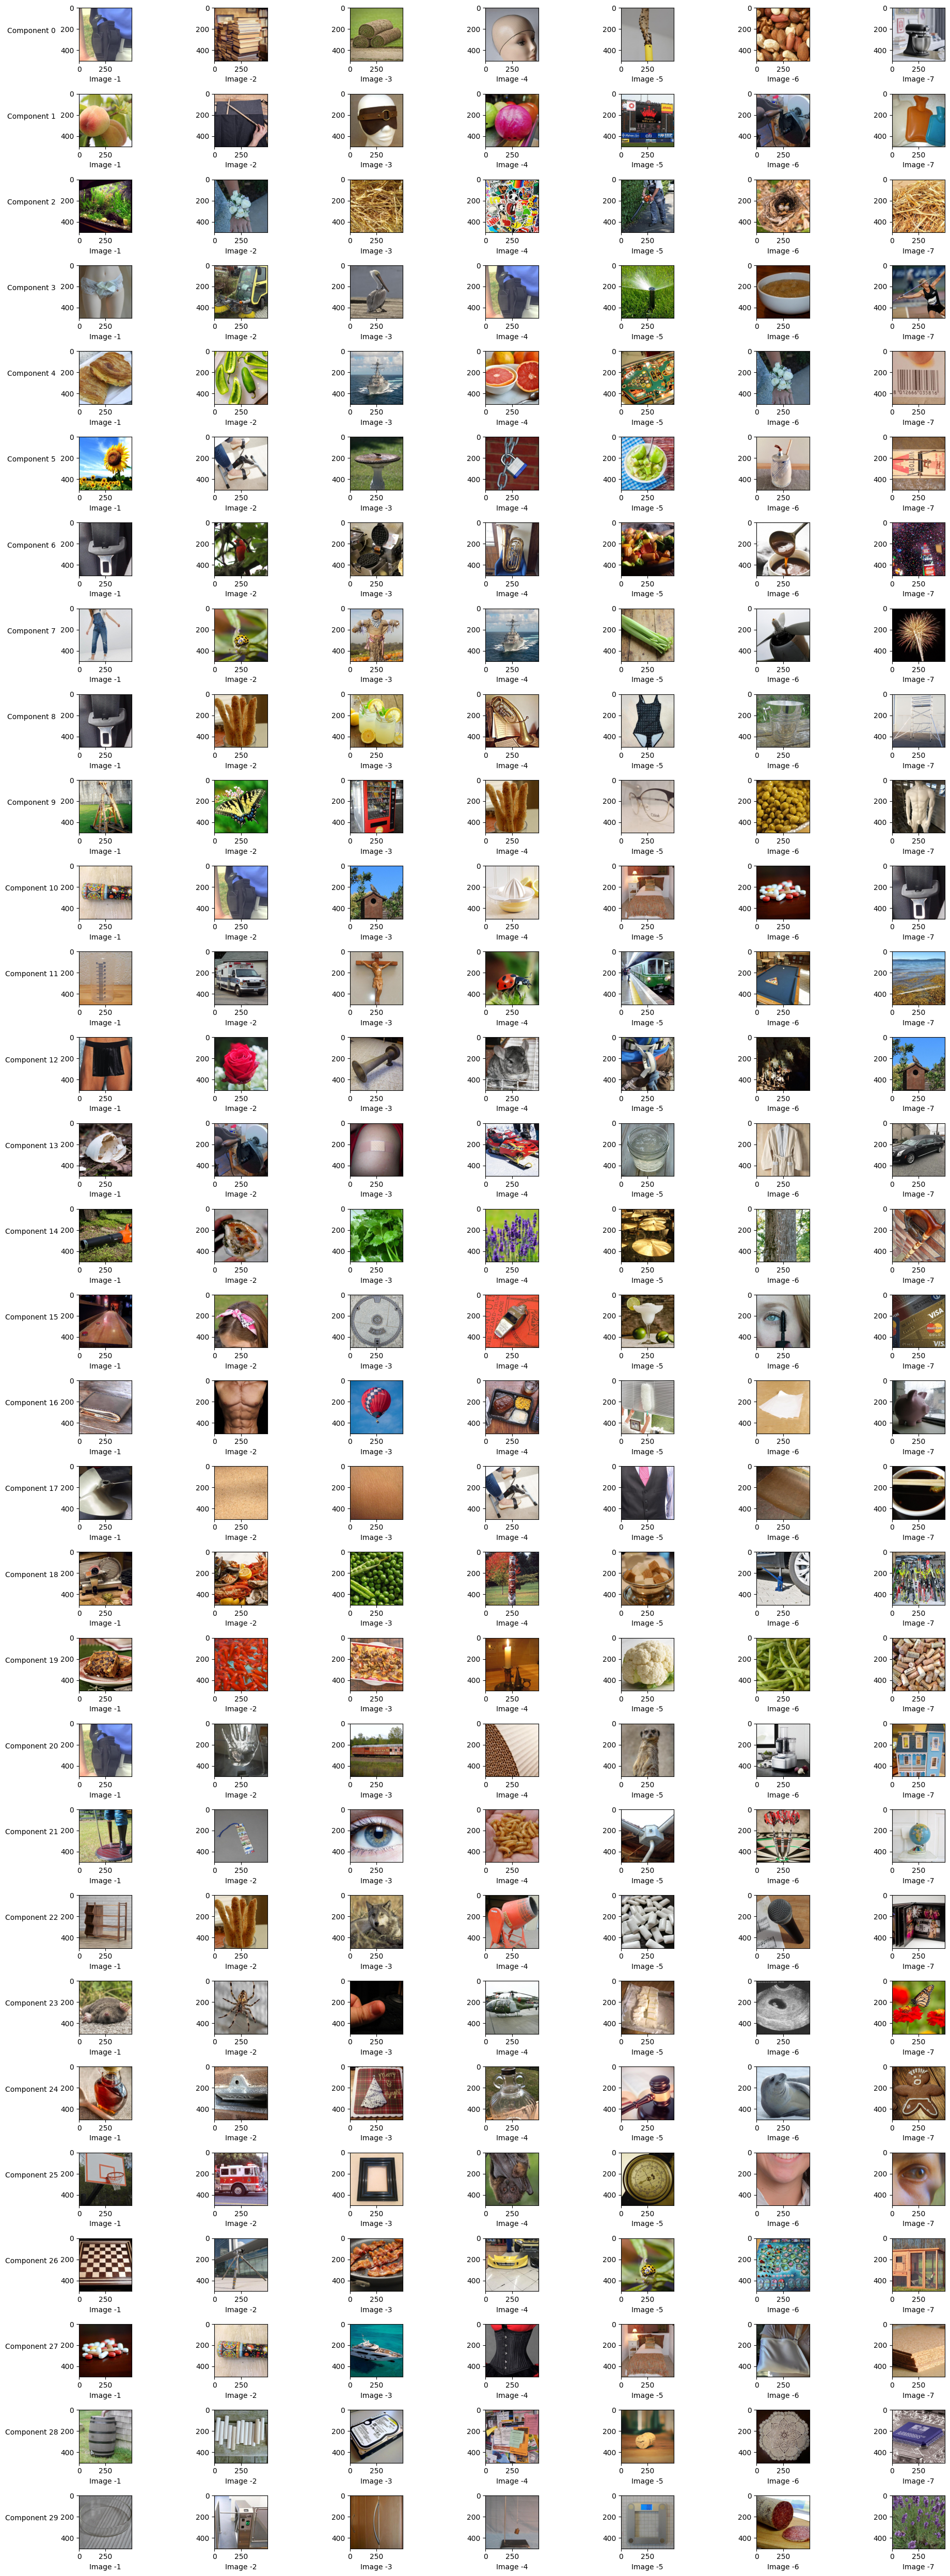

In [25]:
# subplot top images for all components
images_to_plot = 7
fig, ax = plt.subplots(n_components, images_to_plot, figsize=(20, 50))

for i in range(n_components):
    for j in range(images_to_plot):
        ax[i, j].imshow(image_array[int(image_array_sorted[i, -j-1])])   # -ve sign to get the last images as argsort makes ascending order
        # ax[i, j].axis('off')
        # Set the x-axis label as the image number
        ax[i, j].set_xlabel(f'Image {-j-1 }')
    # Set the y-axis label as the component number
    ax[i, 0].set_ylabel(f'Component {i }', rotation=0, labelpad=40)

plt.tight_layout()
plt.show()

In [46]:
# BAYESIAN = 1
# if BAYESIAN:
#     W, H = fit_bnmf(X, 10)
#     X_pred = np.dot(W, H)
# else:
#     model = NMF(n_components=n_components)
#     W = model.fit_transform(X)
#     H = model.components_
#     X_pred = np.dot(W, H)

In [47]:
# W.shape, H.shape # images x componentes, components x time*channels
# # save W, H 
# np.save(f"W_{n_components}.npy", W)
# np.save(f"H_{n_components}.npy", H)

In [48]:
pred_eeg = X_pred.reshape(NOS_IMAGES, NOS_CHANNELS, NOS_TIME_POINTS) # shape: imgx channels x times

ValueError: cannot reshape array of size 22494400 into shape (16540,17,100)

In [45]:
# plot any EEG line
correlation_matrix = np.zeros((NOS_IMAGES, NOS_CHANNELS))
for img in tqdm(range(NOS_IMAGES)):
    for channel in range(NOS_CHANNELS):
        # img = 1
        # channel = 1
        # plt.subplots(1,2, figsize=(10,5))
        # plt.subplot(1,2,1)
        # plt.plot(training_ave_over_reps[img_no,channel,:])
        # plt.subplot(1,2,2)    
        # plt.plot(pred_eeg[img_no,channel,:])
        # plt.show()
        correlation_matrix[img, channel] = np.corrcoef(training_ave_over_reps[img,channel,:],pred_eeg[img,channel,:])[0,1]
        # print(np.corrcoef(training_ave_over_reps[img,channel,:],pred_eeg[img,channel,:])[0,1])

 54%|█████▎    | 8850/16540 [00:06<00:05, 1405.69it/s]

100%|██████████| 16540/16540 [00:11<00:00, 1386.77it/s]


In [46]:
np.max(correlation_matrix, axis= 1)

array([0.93848222, 0.85457968, 0.80583198, ..., 0.94595192, 0.81508924,
       0.91840587])

In [47]:
img = 2
channel = 1
plt.(f"Image:{img} & channel: {channel}")
plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Actual EEG")
plt.plot(training_ave_over_reps[img,channel,:])
plt.subplot(1,2,2)
plt.title("Predicted EEG")
plt.plot(pred_eeg[img,channel,:])
plt.show()

SyntaxError: invalid syntax (4144906278.py, line 3)

In [13]:
# num_components = 40
# W, H = fit_bnmf(X, num_components)
# X_pred = np.dot(W, H)
# tqdm.write(f"Num components:{num_components} Sum(Abs()) = {np.mean(np.abs((X - X_pred)))}")

Num components:40 Sum(Abs()) = 0.21963746575438597


In [84]:
# num_components = 100
# W, H = fit_bnmf(X, num_components)
# X_pred = np.dot(W, H)
# tqdm.write(f"Num components:{num_components} Sum(Abs()) = {np.mean(np.abs((X - X_pred)))}")

Num components:100 Sum(Abs()) = 0.1772618019108304


In [85]:
# num_components = 200
# W, H = fit_bnmf(X, num_components)
# X_pred = np.dot(W, H)
# tqdm.write(f"Num components:{num_components} Sum(Abs()) = {np.mean(np.abs((X - X_pred)))}")

Num components:200 Sum(Abs()) = 0.13860608076293063


In [18]:
compute_evar_all(X, W, H)

0.9999886304678721

In [14]:
evar_indiv = np.zeros(40)
for i in range(40):
    print(f"{i}: {compute_evar_indiv(X, W, H, i)}")
    evar_indiv[i] = compute_evar_indiv(X, W, H, i)
evar_indiv

0: 0.00426479877741881
1: 0.0031071150533202863
2: 0.0025423116233695975
3: 0.002199912596984821
4: 0.0023274031236586445
5: 0.00197219926355674
6: 0.002104634913495218
7: 0.0020812536741702248
8: 0.0016481617085328804
9: 0.002029022680812842
10: 0.0018046461648766332
11: 0.0017150436493044152
12: 0.001734299244766646
13: 0.001600746471535408
14: 0.0012049463505858782
15: 0.0015166982393016726
16: 0.0012287319282273668
17: 0.0013176785157233972
18: 0.0013437736711293669
19: 0.0010911411307338303
20: 0.001361993068182521
21: 0.0011720560822124915
22: 0.0011784308985886005
23: 0.001041641748363964
24: 0.0012213853827370835
25: 0.0009252306498644947
26: 0.0010751877463146542
27: 0.0011733472517819754
28: 0.0008250029259865288
29: 0.0010587087277672547
30: 0.0010421168655166957
31: 0.0008901841606452354
32: 0.001093635702438589
33: 0.000995386810380472
34: 0.0011326058868453837
35: 0.001133343370142259
36: 0.00107972305807158
37: 0.0005202094345106989
38: 0.0005496807501932377
39: 0.999079

IndexError: index 40 is out of bounds for axis 1 with size 40

In [14]:
for i in range(40):
    print(f"{i}: {compute_evar_unique(X, W, H, i)}")

TypeError: compute_evar_unique() missing 1 required positional argument: 'evar_all'

In [87]:
num_components = 500
W, H = fit_bnmf(X, num_components)
X_pred = np.dot(W, H)
tqdm.write(f"Num components:{num_components} Sum(Abs()) = {np.mean(np.abs((X - X_pred)))}")

KeyboardInterrupt: 